## Self-Critical Sequence Training

In [1]:
import imp

import torch
from torchtext.legacy.data import BucketIterator

from preprocess import process_dataset, process_dataset_bert
import train
from score import show_results
from models import GRU_attention

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output


In [3]:
path_to_data = 'data.txt'
train_data, valid_data, test_data, SRC, TRG = process_dataset(path_to_data)

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500
Unique tokens in source (ru) vocabulary: 9261
Unique tokens in target (en) vocabulary: 6703


### Supervised Training

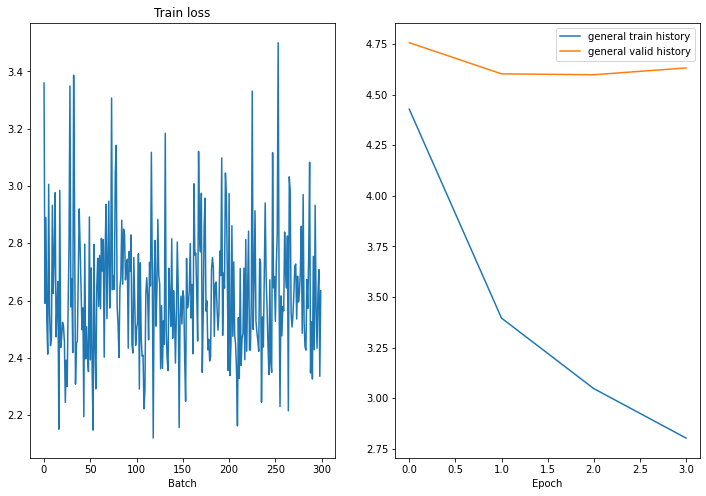

313it [02:04,  2.52it/s]


Epoch: 05 | Time: 2m 6s
	Train Loss: 2.622 | Train PPL:  13.764
	 Val. Loss: 4.612 |  Val. PPL: 100.700


In [34]:
gru_model, test_iterator =  train.train_model(train_data, valid_data, test_data, SRC, TRG,
                                           GRU_attention, 'GRU_attention_SCST_5_epoch', batch_size=128, n_epochs=5)

In [42]:
torch.save(gru_model.state_dict(), f'artifacts/GRU_attention_SCST_5_epoch.pt')

In [57]:
def _len_sort_key(x):
        return len(x.src)
BATCH_SIZE = 128
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

path_to_data = 'data.txt'
train_data, valid_data, test_data, SRC, TRG = process_dataset(path_to_data)

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
        (train_data, valid_data, test_data), 
        batch_size=BATCH_SIZE, device=device, sort_key=_len_sort_key,
    )

gru_model = train.load_best_model('GRU_attention_SCST_5_epoch', GRU_attention, SRC, TRG, test_iterator)
show_results(gru_model, test_iterator, TRG)

2it [00:00, 18.96it/s]

| Test Loss: 4.594 | Test PPL:  98.876 |
The model has 16,474,671 trainable parameters


59it [00:05, 11.38it/s]


BLEU: 23.797037619150423

original: there is a private bathroom with a bath or shower .
translated: the private bathroom comes with a bath or shower .

original: they also have a fan and a good - sized private bathroom .
translated: private bathroom has a fan and a private bathroom .

original: some rooms have a spa bath , and all offers mountains view .
translated: some rooms have views of the mountain and some rooms have a mountain views .

original: it features self - catering apartments as well as a large garden with a playground , table tennis and barbecue facilities .
translated: self - catering accommodation features a garden and a children ’ s playground , a tennis court , a tennis court and a table .

original: at lion sea hotel , guests can request for luggage storage , laundry services and barbecue facilities .
translated: other facilities offered at the property include luggage storage , laundry facilities and laundry facilities .



Бейзлайн-качество: **23.8** BLEU

### Training with Policy Gradient

In [6]:
import torch.nn.functional as F
import tqdm
import numpy as np
from tqdm import trange
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu

from score import bleu_score
import utils


get_text = utils.get_text

def translate_batch(model, src, trg, device=device, greedy=False):
    batch_size = trg.shape[1]
    max_len = trg.shape[0]
    logits = model(src, trg, 0)
    if greedy:
        res = logits.argmax(dim=-1)
    else:
        res = torch.zeros(max_len, batch_size, dtype=torch.int, device=device)
        probs = F.softmax(logits, dim=-1)
        for i in range(max_len):
            res[i, :] = torch.multinomial(probs[i, :, :], 1)[:, 0]
    return res, F.log_softmax(logits, dim=-1) # logits

def get_sent_bleu(orig_text, gen_text):
    return sentence_bleu([orig_text], gen_text)

def compute_reward(orig_text, gen_text):
    scores = list(map(get_sent_bleu, orig_text, gen_text))
    return torch.tensor(scores)

def to_one_hot(y, n_dims=None):
    """ Take integer y (tensor or variable) with n dims and convert it to 1-hot representation with n+1 dims. """
    y_tensor = y.data
    y_tensor = y_tensor.to(dtype=torch.long).view(-1, 1)
    n_dims = n_dims if n_dims is not None else int(torch.max(y_tensor)) + 1
    y_one_hot = torch.zeros(y_tensor.size()[0], n_dims, device=y.device).scatter_(1, y_tensor, 1)
    y_one_hot = y_one_hot.view(*y.shape, -1)
    return y_one_hot

def infer_mask(seq, eos_ix, batch_first=False, include_eos=True, dtype=torch.float):
    """
    compute length given output indices and eos code
    :param seq: tf matrix [time,batch] if batch_first else [batch,time]
    :param eos_ix: integer index of end-of-sentence token
    :param include_eos: if True, the time-step where eos first occurs is has mask = 1
    :returns: lengths, int32 vector of shape [batch]
    """
    assert seq.dim() == 2
    is_eos = (seq == eos_ix).to(dtype=torch.float)
    if include_eos:
        if batch_first:
            is_eos = torch.cat((is_eos[:,:1]*0, is_eos[:, :-1]), dim=1)
        else:
            is_eos = torch.cat((is_eos[:1,:]*0, is_eos[:-1, :]), dim=0)
    count_eos = torch.cumsum(is_eos, dim=1 if batch_first else 0)
    mask = count_eos == 0
    return mask.to(dtype=dtype)

def scst_objective_on_batch(model, src, trg, TRG, device=device):
    """ Compute pseudo-loss for policy gradient given a batch of sources """
    input_sequence = [get_text(x, TRG.vocab) for x in trg.cpu().numpy().T]

    # use model to __sample__ symbolic translations given input_sequence
    sample_translations, sample_logp = translate_batch(model, src, trg, device=device, greedy=False)
    sample_translations, sample_logp = sample_translations[1:], sample_logp[1:]
    # use model to __greedy__ symbolic translations given input_sequence
    greedy_translations, greedy_logp = translate_batch(model, src, trg, device=device, greedy=True)
    greedy_translations, greedy_logp = greedy_translations[1:], greedy_logp[1:]
    
    # compute rewards and advantage
    sample_text = [get_text(x, TRG.vocab) for x in sample_translations.detach().cpu().numpy().T]
    greedy_text = [get_text(x, TRG.vocab) for x in greedy_translations.detach().cpu().numpy().T]

    rewards = compute_reward(input_sequence, sample_text)
    baseline = compute_reward(input_sequence, greedy_text)

    # compute advantage using rewards and baseline
    advantage = (rewards - baseline).float().to(device)

    # compute log_pi(a_t|s_t), shape = [batch, seq_length]
    logp_sample = torch.sum(to_one_hot(sample_translations, n_dims=len(TRG.vocab)) * sample_logp, dim=-1)
    # policy gradient pseudo-loss. Gradient of J is exactly policy gradient.
    J = logp_sample * advantage[:, None].T

    assert J.dim() == 2, "please return elementwise objective, don't compute mean just yet"

    # average with mask
    mask = infer_mask(sample_translations, TRG.vocab[TRG.eos_token])#.T
    loss = - torch.sum(J * mask) / torch.sum(mask)

    # regularize with negative entropy.
    entropy = - torch.sum(torch.exp(sample_logp) * sample_logp, dim=-1)#.T

    assert entropy.dim(
    ) == 2, "please make sure elementwise entropy is of shape [batch,time]"
    
    reg = - 0.01 * torch.sum(entropy * mask) / torch.sum(mask)

    return loss + reg, torch.sum(entropy * mask) / torch.sum(mask)

In [104]:
model = gru_model

| Test Loss: 4.594 | Test PPL:  98.876 |



0it [00:00, ?it/s]
2it [00:00, 19.90it/s]
4it [00:00, 19.27it/s]
6it [00:00, 17.86it/s]
8it [00:00, 16.71it/s]
10it [00:00, 14.82it/s]
12it [00:00, 13.73it/s]
14it [00:00, 12.90it/s]
16it [00:01, 11.92it/s]
18it [00:01, 10.63it/s]
20it [00:01, 11.69it/s]


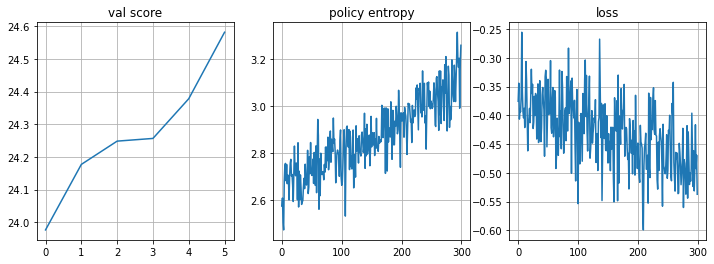

300it [03:11,  1.45s/it]

Epoch: 1, J=-0.478, mean score=24.270


313it [03:18,  1.58it/s]


In [105]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

loss_history = []
bleu_history = []
entropy_history = []
opt = torch.optim.Adam(model.parameters(), lr=1e-5)

REPORT_FREQ = 50
N_EPOCHS = 1

for epoch in range(N_EPOCHS):
    for i, batch in tqdm.tqdm(enumerate(train_iterator)):
        model.train()
        src = batch.src
        trg = batch.trg
        loss, ent = scst_objective_on_batch(model, src, trg, TRG, device)

        loss.backward()
        opt.step()
        opt.zero_grad()
        loss_history.append(loss.item())
        entropy_history.append(ent.item())

        if (i+1) % REPORT_FREQ == 0:
            clear_output(True)
            current_bleu, _, _ = bleu_score(model, valid_iterator, TRG)
            bleu_history.append(current_bleu)
            plt.figure(figsize=(12, 4))
            plt.subplot(131)
            plt.title('val score')
            plt.plot(bleu_history)
            plt.grid()
            plt.subplot(132)
            plt.title('policy entropy')
            plt.plot(entropy_history)
            plt.grid()
            plt.subplot(133)
            plt.title('loss')
            plt.plot(loss_history)
            plt.grid()
            plt.show()
            print("Epoch: %d, J=%.3f, mean score=%.3f" %
                  (epoch, np.mean(loss_history[-10:]), np.mean(bleu_history[-10:])))

In [106]:
show_results(model, test_iterator, TRG)

2it [00:00, 14.26it/s]

The model has 16,474,671 trainable parameters


59it [00:05, 11.12it/s]


BLEU: 24.145048357024375

original: the regional airport is just 11 minutes ' drive away .
translated: the international airport is just a 20 - minute drive away .

original: a simple breakfast with toast and jam , cereals , tea and coffee is provided each morning .
translated: coffee , toast , eggs , coffee and coffee juices are served in the morning .

original: hotel offers transfers from airport , as well as excursions to mountain , boating and rafting on the river cetina , safari ( quad ) or trips to national parks of krka waterfalls and lakes .
translated: the boat airport , the , , , boat trips trips to the island , and the island island island can be arranged for rafting , rafting and rafting safaris .

original: restaurants and cafes are 1 km away .
translated: restaurants and cafés are be found within 1 km from the property .

original: the on site restaurant serves a selection of international dishes .
translated: international cuisine international dishes are served at the 

Качество после SCST: **24.15**. Итоговый прирост составил **0.35 BLEU** после одной эпохи дообучения.